Homography Matrix (RANSAC):
[[-4.91777017e-01 -8.79589299e-01  4.09242860e+02]
 [-2.26549261e-02 -2.65394958e-02  1.64785881e+01]
 [-1.23574624e-03 -2.12829541e-03  1.00000000e+00]]
Homography Matrix (Dataset):
[[ 6.2544644e-01  5.7759174e-02  2.2201217e+02]
 [ 2.2240536e-01  1.1652147e+00 -2.5605611e+01]
 [ 4.9212545e-04 -3.6542424e-05  1.0000000e+00]]


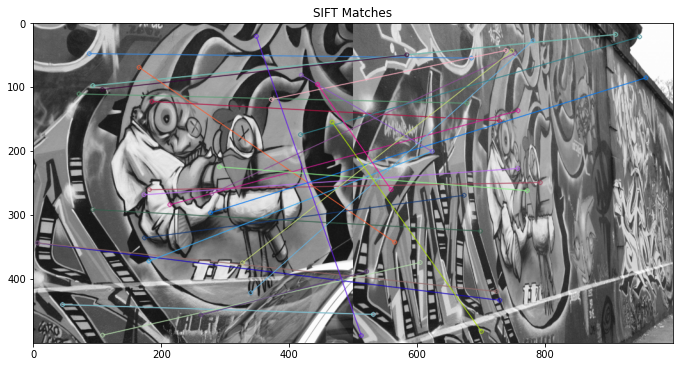

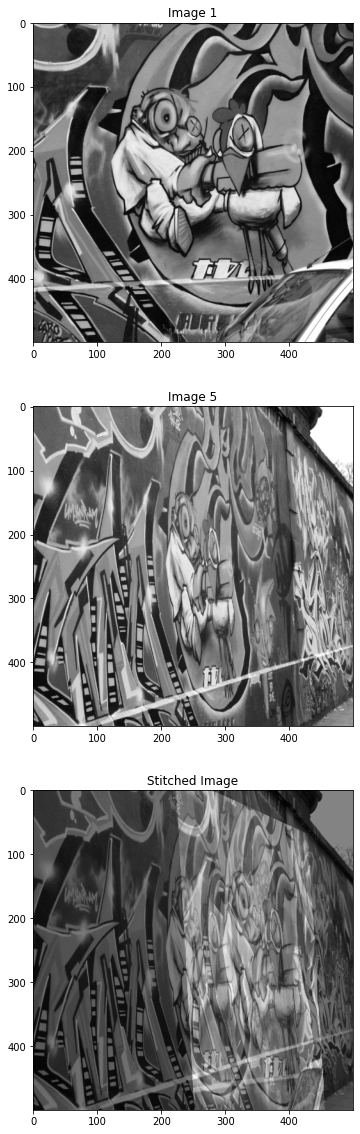

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the images
img1 = cv2.imread('img1.ppm', cv2.IMREAD_GRAYSCALE)
img5 = cv2.imread('img5.ppm', cv2.IMREAD_GRAYSCALE)

# Resize images to a common size
common_size = (500, 500)
img1_resized = cv2.resize(img1, common_size)
img5_resized = cv2.resize(img5, common_size)

# Step (a): Compute and match SIFT features
sift = cv2.SIFT_create()

# Find the keypoints and descriptors with SIFT
keypoints1, descriptors1 = sift.detectAndCompute(img1_resized, None)
keypoints5, descriptors5 = sift.detectAndCompute(img5_resized, None)
# Use a brute force matcher to find the best matches
bf = cv2.BFMatcher()
matches = bf.knnMatch(descriptors1, descriptors5, k=2)

# Apply ratio test to select good matches
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

# Draw the matches using Matplotlib
img_matches = cv2.drawMatches(img1_resized, keypoints1, img5_resized, keypoints5, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize=(40, 20))
plt.subplot(3, 1, 1), plt.imshow(img_matches), plt.title('SIFT Matches')

# Step (b): Compute the homography using RANSAC
if len(good_matches) >= 4:
    src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([keypoints5[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

    # Use RANSAC to estimate the homography
    homography, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

    # Print the computed homography matrix
    print("Homography Matrix (RANSAC):")
    print(homography)

    #Homograph Given in the File
    dataset_homography = np.array([[6.2544644e-01,   5.7759174e-02,   2.2201217e+02],
   [2.2240536e-01,   1.1652147e+00,  -2.5605611e+01],
   [4.9212545e-04,  -3.6542424e-05,   1.0000000e+00]])
    print("Homography Matrix (Dataset):")
    print(dataset_homography)
else:
    print("Not enough matches to compute homography.")

# Step (c): Stitch img1 onto img5 using the computed homography
if homography is not None:
    
    # Warp the image using the homography
    img1_warped = cv2.warpPerspective(img1_resized, dataset_homography, common_size)
    # Combine the images
    result = cv2.addWeighted(img5_resized, 0.5, img1_warped, 0.5, 0)
    
    plt.figure(figsize=(40, 20))
    # Display the images
    plt.subplot(3, 1, 1), plt.imshow(img1_resized, cmap='gray'), plt.title('Image 1')
    plt.subplot(3, 1, 2), plt.imshow(img5_resized, cmap='gray'), plt.title('Image 5')
    plt.subplot(3, 1, 3), plt.imshow(result, cmap='gray'), plt.title('Stitched Image')
    plt.show()
else:
    print("Homography not computed, cannot perform stitching.")
